# Using ChatGPT to predict the Oscars

## How to use ChatGPT to build a model to predict who will win Best Picture at the 2023 Academy Awards

This notebook is the full code as described in the blog post (insert link)

In [2]:
import config # to hide TMDB API keys
import requests # to make TMDB API calls
import locale # to format currency as USD
locale.setlocale( locale.LC_ALL, '' )

import pandas as pd
#import matplotlib
import matplotlib.pyplot as plt
#from matplotlib.ticker import FuncFormatter # to format currency on charts axis

import itertools
from pandas import json_normalize 
import networkx as nx
import datetime

api_key = config.tmdb_api_key # get TMDB API key from config.py file

from matplotlib import pyplot as plt
import seaborn as sns

## Get data for all nominees and winners for Oscars over time

In [139]:
#This data came from this Kaggle contest: https://www.kaggle.com/datasets/unanimad/the-oscar-award?resource=download
df = pd.read_csv("the_oscar_award.csv")

In [141]:
df.head()

,year_film,year_ceremony,ceremony,category,name,film,winner
0,1927,1928,1,ACTOR,Richard Barthelmess,The Noose,False
1,1927,1928,1,ACTOR,Emil Jannings,The Last Command,True
2,1927,1928,1,ACTRESS,Louise Dresser,A Ship Comes In,False
3,1927,1928,1,ACTRESS,Janet Gaynor,7th Heaven,True
4,1927,1928,1,ACTRESS,Gloria Swanson,Sadie Thompson,False


## Get the TMDB ID for all of the films on this list (this takes a while to run)

In [142]:
# Get a list of unique movie names and years
unique_movies = df[['film', 'year_film']].drop_duplicates()

# Create an empty dictionary to store the movie IDs
movie_ids = {}

# Loop over the unique movie names and query the TMDB API for the ID
for i, row in unique_movies.iterrows():
    # Construct the API URL
    url = f"https://api.themoviedb.org/3/search/movie?api_key={api_key}&query={row['film']}&year={row['year_film']}"
    
    # Query the API
    response = requests.get(url)
    data = response.json()
    
    # Extract the movie ID if the search is successful
    if data['total_results'] > 0:
        movie_id = data['results'][0]['id']
        movie_name = f"{row['film']} ({row['year_film']})"
        movie_ids[movie_name] = movie_id

# Update the dataframe with the movie IDs
df['tmdb_id'] = df.apply(lambda x: movie_ids.get(f"{x['film']} ({x['year_film']})", ""), axis=1)


In [596]:
len(df)

92979

Write to a csv to save progress

In [143]:
df.to_csv("oscarsWithTMDBID.csv")
df = pd.read_csv("oscarsWithTMDBID.csv")

In [276]:
print(str(df['film'].nunique())+ " unique movies in this list")
print(str(df['tmdb_id'].nunique()) + " unique TMDB IDs in this list")

4990 unique movies in this list
4738 unique TMDB IDs in this list


Manually add in a bunch of IDs

In [303]:
missingTMDBIDs = {
    "Judas and the Black Messiah" : 583406,
    "The United States vs. Billie Holiday" : 566076,
    "Angels and Insects" : 8447,
    "Good Fellas" : 769,
    "My Brilliant Career" : 16659,
    "The Great Santini" : 21887,
    "Amarcord" : 7857,
    "The Producers" : 30197,
    "Woman in the Dunes" : 16672,
    "Meredith Willson's The Music Man" : 13671,
    "The Bridges at Toko-Ri" : 35580,
    "One Hundred Men and a Girl" : 61647,
    "In Old Chicago" : 78734,
    "A Tale of Two Cities" : 17831,
    "Eskimo" : 113638,
    "State Fair" : 52517,
    "She Done Him Wrong" : 43595,
    "The Private Life of Henry VIII" : 43122,
    "Little Women" : 39938,
    "Lady for a Day" : 43130,
    "42nd Street" : 3062,
    "Cavalcade" : 56164,
    "Reunion in Vienna" : 174116,
    "Shanghai Express" : 875,
    "One Hour with You" : 43145,
    "Trader Horn" : 84296,
    "Skippy" : 84295,
    "The Front Page" : 42814,
    "East Lynne" : 84277,
    "Cimarron" : 42861,
    "A Free Soul" : 50600,
    "Tabu" : 977,
    "Svengali" : 45803,
    "The Divorcee" : 80708,
    "The Big House" : 47250,
    "All Quiet on the Western Front" : 143,
    "Anna Christie;" : 42812,
    "With Byrd at the South Pole" : 101383,
    "Hell's Angels" : 22301,
    "Anna Christie" : 42812,
    "Hollywood Revue" : 31678,
    "The Broadway Melody" : 65203,
    "Alibi" : 13847,
    "The Divine Lady" : 104214,
    "Madame X" : 39075,
    "The Racket" : 27777,
}

In [304]:
#Fill in missing IDs from the dict above
df['tmdb_id'] = df['tmdb_id'].fillna(df['film'].apply(lambda x: missingTMDBIDs.get(x)))

## Use TMDB API to get info on each of these films, including IMDB ID

In [363]:
# Convert 'tmdb_id' column to integer type
df['tmdb_id'] = df['tmdb_id'].astype(str).replace('\.0', '', regex=True)

# Get unique tmdb_id values
unique_tmdb_ids = df['tmdb_id'].unique()

# Create an empty list to store movie details
movies = []

# Loop over unique tmdb_id values and query the API for each movie
for tmdb_id in unique_tmdb_ids:
    #print(tmdb_id)
    url = f"https://api.themoviedb.org/3/movie/{tmdb_id}?api_key={api_key}&language=en-US"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        movie = data
        movies.append(movie)
    else:
        print(f"Error getting data for tmdb_id={tmdb_id}")

    # Extract all information for each movie
    movie = data
    movies.append(movie)

# Create a new dataframe with the movie details
movies_df = pd.DataFrame(movies)

# Rename the 'id' column to 'tmdb_id'
movies_df = movies_df.rename(columns={'id': 'tmdb_id'})

movies_df['tmdb_id'] = movies_df['tmdb_id'].astype(str).replace('\.0', '', regex=True)

# Merge the new dataframe with the original dataframe on 'tmdb_id'
merged_df = df.merge(movies_df, on='tmdb_id')


Error getting data for tmdb_id=nan


In [ ]:
#Write to csv to save progress
merged_df.to_csv("merged_df.csv")

## Extract individual names from the name column

In [755]:
df = pd.read_csv("merged_df.csv")

#Clean a little and remove duplicates
df = df.iloc[:,2:]
df = df.drop_duplicates()

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [756]:
from flair.models import SequenceTagger
from flair.data import Sentence

tagger = SequenceTagger.load('ner')

# define function to extract names from text
def extract_names(text):
    sentence = Sentence(text)
    tagger.predict(sentence)
    names = []
    for entity in sentence.get_spans('ner'):
        if entity.tag == 'PER':
            names.append(entity.text.strip())
    return names

# create a new dataframe to store the split names
new_df = pd.DataFrame(columns=df.columns)

# iterate over each row in the original dataframe
for index, row in df.iterrows():
    # check if the value in the 'credits' column is a string
    if isinstance(row['name'], str):
        # extract names from the 'credits' column using the extract_names function
        names = extract_names(row['name'])
        # iterate over each extracted name
        for name in names:
            # create a new row in the new dataframe for each extracted name
            new_row = row.copy()
            new_row['name'] = name
            new_df = new_df.append(new_row)
    else:
        # if the value is not a string, just append the row to the new dataframe
        new_df = new_df.append(row)

# reset the index of the new dataframe
new_df = new_df.reset_index(drop=True)

/opt/anaconda3/lib/python3.8/site-packages/huggingface_hub/file_download.py:629: FutureWarning: `cached_download` is the legacy way to download files from the HF hub, please consider upgrading to `hf_hub_download`
  warnings.warn(


2023-03-01 08:50:30,376 loading file /Users/stevehedden/.flair/models/ner-english/4f4cdab26f24cb98b732b389e6cebc646c36f54cfd6e0b7d3b90b25656e4262f.8baa8ae8795f4df80b28e7f7b61d788ecbb057d1dc85aacb316f1bd02837a4a4
2023-03-01 08:50:34,704 SequenceTagger predicts: Dictionary with 20 tags: <unk>, O, S-ORG, S-MISC, B-PER, E-PER, S-LOC, B-ORG, E-ORG, I-PER, S-PER, B-MISC, I-MISC, E-MISC, I-ORG, B-LOC, E-LOC, I-LOC, <START>, <STOP>


In [759]:
#Looks like all of the names are separated into their own rows
new_df.loc[new_df['film'] == "Triangle of Sadness"]

,year_film,year_ceremony,ceremony,category,name,film,winner,tmdb_id,adult,backdrop_path,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
14674,2022,2023,95,Directing,Ruben Östlund,Triangle of Sadness,NaN,497828,False,/pEwyF5rdnNqdesnZIADMZSd8peQ.jpg,...,2022-09-23,23500000,147,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Triangle of Sadness,False,7.349,789
14675,2022,2023,95,Best Picture,Erik Hemmendorff,Triangle of Sadness,NaN,497828,False,/pEwyF5rdnNqdesnZIADMZSd8peQ.jpg,...,2022-09-23,23500000,147,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Triangle of Sadness,False,7.349,789
14676,2022,2023,95,Best Picture,Philippe Bober,Triangle of Sadness,NaN,497828,False,/pEwyF5rdnNqdesnZIADMZSd8peQ.jpg,...,2022-09-23,23500000,147,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Triangle of Sadness,False,7.349,789
14677,2022,2023,95,Writing (Original Screenplay),Ruben Östlund,Triangle of Sadness,NaN,497828,False,/pEwyF5rdnNqdesnZIADMZSd8peQ.jpg,...,2022-09-23,23500000,147,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Triangle of Sadness,False,7.349,789


In [951]:
df = df.loc[~df['name'].isna()]

## Count the number of previous nominations and wins each person has

In [953]:

# create dictionaries to store previous nominations and wins for each name
previous_nominations = {}
previous_wins = {}

# loop through each row in the dataframe
for index, row in df.iterrows():

    # extract the name and ceremony year from the current row
    name = row["name"]
    year = row["year_ceremony"]

    # check if the name has already appeared in previous ceremonies
    if name in previous_nominations:

        # count the number of previous nominations and wins for the current name
        previous_nom = sum([1 for x in previous_nominations.get(name, []) if x < year])
        previous_win = sum([1 for x in previous_wins.get(name, []) if x < year])


    else:
        # if the name hasn't appeared in previous ceremonies, set the counts to 0
        previous_nom = 0
        previous_win = 0

    # update the previous nominations and wins dictionaries for the current name and ceremony year
    previous_nominations.setdefault(name, []).append(year)
    if row["winner"] == True:
        previous_wins.setdefault(name, []).append(year)

    # assign the previous nomination and win counts to new columns in the dataframe
    df.at[index, "previous_nominations"] = previous_nom
    df.at[index, "previous_wins"] = previous_win

# convert the columns to integers
df["previous_nominations"] = df["previous_nominations"].astype(int)
df["previous_wins"] = df["previous_wins"].astype(int)



/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
<ipython-input-953-4308e6973a57>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

In [954]:
df.to_csv("merged_df_previousWins.csv")

In [1043]:
df = pd.read_csv("merged_df_previousWins.csv")

In [1045]:
df['other_noms'] = df.groupby(['film','year_film'])['category'].transform('nunique')

In [1046]:
#df.loc[df['film'] == "All Quiet on the Western Front"]

In [1047]:
#Filter for just best picture nominees
df = df.loc[(df['category'] == "Best Picture") | 
       (df['category'] == "BEST PICTURE") | 
       (df['category'] == "BEST MOTION PICTURE") |
       (df['category'] == "OUTSTANDING MOTION PICTURE") |
       (df['category'] == "OUTSTANDING PRODUCTION") | 
       (df['category'] == "OUTSTANDING PICTURE")]

## Get ratings from OMDB

In [1048]:
# Set the OMDB API key
api_key = config.omdb_api_key # get TMDB API key from config.py file

# Create an empty list to store the scores for each movie
scores = []

# Loop through each row in the dataframe and search for the movie using the OMDB API
for index, row in df.iterrows():
    # Extract the IMDB ID from the row
    imdb_id = row["imdb_id"]
    
    # Make a request to the API and parse the response as JSON
    response = requests.get(f"http://www.omdbapi.com/?i={imdb_id}&apikey={api_key}")
    data = response.json()
    
    # Extract the ratings from the response
    ratings = {"imdb_rating": None, "rotten_tomatoes_rating": None, "metacritic_rating": None}
    for rating in data.get("Ratings", []):
        if rating["Source"] == "Rotten Tomatoes":
            ratings["rotten_tomatoes_rating"] = rating["Value"]
        elif rating["Source"] == "Metacritic":
            ratings["metacritic_rating"] = rating["Value"]
        elif rating["Source"] == "Internet Movie Database":
            ratings["imdb_rating"] = rating["Value"]
    
    # Append the ratings to the scores list
    scores.append({
        "imdb_id": imdb_id,
        **ratings
    })

# Create a pandas dataframe from the list of scores
scores_df = pd.DataFrame(scores)

# Merge the scores dataframe with the original dataframe on imdb_id
df = pd.merge(df, scores_df, on="imdb_id", how="left")


In [1049]:
df = df.drop_duplicates()

In [1050]:
df.to_csv("moviesWithRatings.csv")

## Build model and predict outcomes

In [1167]:
df = pd.read_csv("moviesWithRatings.csv")

In [1168]:
df = df.iloc[:,2:]

In [1169]:
#Put these in manually because they are missing for some reason
df.loc[df['film'] == 'Tár', 'rotten_tomatoes_rating'] = 9.1
df.loc[df['film'] == 'The Banshees of Inisherin', 'budget'] = 20000000
df.loc[df['film'] == 'Women Talking', 'budget'] = 134900000

In [1170]:
#df.loc[df['film'] == "All Quiet on the Western Front"]

### Separate genres into their own columns

In [1171]:
from ast import literal_eval

# convert the 'genres' column from a string to a list of dictionaries
df['genres'] = df['genres'].apply(literal_eval)

# create a set of all unique genre names
genre_set = set()
for genres in df['genres']:
    for genre in genres:
        genre_set.add(genre['name'])

# create a new column for each genre
for genre in genre_set:
    df[genre] = 0

# set the value to 1 for each genre that applies to the movie
for index, row in df.iterrows():
    genres = row['genres']
    for genre in genres:
        df.at[index, genre['name']] = 1

# drop the original 'genres' column
df.drop(columns=['genres'], inplace=True)


### Separate original language into their own columns

In [1172]:
# create a set of all unique original language names
language_set = set(df['original_language'])

# create a new column for each original language
for language in language_set:
    df[language] = 0

# set the value to 1 for each original language that applies to the movie
for index, row in df.iterrows():
    language = row['original_language']
    df.at[index, language] = 1

# drop the original 'original_language' column
df.drop(columns=['original_language'], inplace=True)


### What can the genre data tell us about historical wins?

In [1173]:
# create a list of genre column names
genre_columns = ['Horror', 'War', 'Thriller', 'Comedy', 'Family',
                 'Music', 'Western', 'Adventure', 'Drama', 'Romance',
       'Action', 'Science Fiction', 'Fantasy', 'History', 'Mystery',
       'Animation', 'Crime']

# create an empty dictionary to store the counts
genre_counts = {}

# loop through each genre column and count the number of unique films
for genre in genre_columns:
    try:
        total_nominated = len(df.loc[df[genre]==1, 'film'].unique())
        total_wins = len(df.loc[(df[genre]==1) & (df['winner']==True), 'film'].unique())
        genre_counts[genre] = {'Total Unique Films Nominated': total_nominated, 'Total Unique Films Won': total_wins}
    except:
        pass

# convert the dictionary to a dataframe
genre_counts_df = pd.DataFrame.from_dict(genre_counts, orient='index')

# sort the dataframe by the total number of unique films nominated
genre_counts_df = genre_counts_df.sort_values('Total Unique Films Nominated', ascending=False)

# display the dataframe
print(genre_counts_df)


                 Total Unique Films Nominated  Total Unique Films Won
Drama                                     373                      64
Romance                                   119                      23
Comedy                                     82                      15
History                                    76                      16
Thriller                                   55                       8
Crime                                      49                      11
War                                        48                      11
Adventure                                  41                       6
Action                                     35                       6
Music                                      24                       6
Mystery                                    21                       1
Fantasy                                    19                       3
Western                                    17                       2
Science Fiction     

### What about the ratio of noms to wins by genre?

In [1174]:
genre_counts_df['ratio'] = genre_counts_df['Total Unique Films Won'] / genre_counts_df['Total Unique Films Nominated']
genre_counts_df.sort_values(by='ratio',ascending=False)

,Total Unique Films Nominated,Total Unique Films Won,ratio
Family,16,4,0.250000
Music,24,6,0.250000
War,48,11,0.229167
Crime,49,11,0.224490
History,76,16,0.210526
Romance,119,23,0.193277
Comedy,82,15,0.182927
Drama,373,64,0.171582
Action,35,6,0.171429
Fantasy,19,3,0.157895


### How are this year's nominees categorized in terms of genre?

In [1175]:
df.loc[df['year_film'] == 2022][['film'] + genre_columns].drop_duplicates()

,film,Horror,War,Thriller,Comedy,Family,Music,Western,Adventure,Drama,Romance,Action,Science Fiction,Fantasy,History,Mystery,Animation,Crime
825,Elvis,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0
830,The Banshees of Inisherin,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
833,The Fabelmans,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
836,Everything Everywhere All at Once,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0
839,Tár,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
842,All Quiet on the Western Front,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
843,Triangle of Sadness,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
845,Top Gun: Maverick,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
849,Avatar: The Way of Water,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0
851,Women Talking,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


No sci-fi movie has ever won, but 3 fantasy movies have. 
The Shape of Water is labeled as drama, romance, and fantasy but not science-fiction.
Though there are articles about how it was the 'First Sci-Fi movie to win best picture' - https://www.huffpost.com/entry/shape-of-water-oscars_n_5a8ddf4de4b077f5bfeaa1ab

In [1176]:
df.loc[(df['Fantasy'] == 1) & (df['winner'] == True)][['film']].drop_duplicates()

,film
45,Around the World in 80 Days
413,The Lord of the Rings: The Return of the King
714,The Shape of Water


In [1177]:
#List of sci-fi films that didn't win
df.loc[(df['Science Fiction'] == 1) & (df['winner'] == False)][['film']].drop_duplicates()

,film
127,A Clockwork Orange
169,Star Wars
210,E.T. The Extra-Terrestrial
502,Avatar
504,District 9
533,Inception
604,Gravity
609,Her
640,The Martian
662,Mad Max: Fury Road


### Separate genres into the 'major' genres and the less frequent (less than 5 percent) genres

In [1178]:
genre_columns = [ 'Horror', 'War', 'Thriller', 'Comedy', 'Family',
                 'Music', 'Western', 'Adventure', 'Drama', 'Romance',
                 'Action', 'Science Fiction', 'Fantasy', 'History', 'Mystery',
                 'Animation', 'Crime']

# Calculate the frequency of each genre
genre_freq = df[genre_columns].sum() / len(df)

# Create a list of genres to be included in the "Other" category
other_genres = list(genre_freq[genre_freq < 0.05].index)

# Add up the columns of genres that are frequently occurring
frequent_genres = [col for col in genre_columns if col not in other_genres]
df['Frequent_Genres'] = df[frequent_genres].sum(axis=1)

# Set the value of the "Other" category to 1 if any of the infrequent genres are present
df['Other'] = df[other_genres].max(axis=1)

# Drop the original genre columns
df.drop(columns=genre_columns, inplace=True)


In [1179]:
other_genres

['Horror', 'Family', 'Western', 'Science Fiction', 'Fantasy', 'Animation']

In [1180]:
df = df.rename(columns={"en": "english_language", "Other": "genre"})

In [1181]:
df.loc[(df['winner'] == True) & (df['genre'] == 1)][['year_film','film']].drop_duplicates()

,year_film,film
24,1952,The Greatest Show on Earth
45,1956,Around the World in 80 Days
93,1965,The Sound of Music
105,1968,Oliver!
267,1990,Dances With Wolves
285,1992,Unforgiven
413,2003,The Lord of the Rings: The Return of the King
714,2017,The Shape of Water


In [1186]:
# create the dictionary with the replacements
replacements = {
    ('All Quiet on the Western Front', 2022): 9,
    ('Everything Everywhere All at Once', 2022): 11,
    ('The Banshees of Inisherin', 2022): 9,
}

# select the rows to be replaced
rows_to_replace = df.loc[(df['film'].isin([film for film, year in replacements.keys()])) & 
                         (df['year_film'].isin([year for film, year in replacements.keys()]))]

# replace the values using the dictionary
df.loc[rows_to_replace.index, 'other_noms'] = rows_to_replace.apply(
    lambda row: replacements[(row['film'], row['year_film'])], axis=1
)


### Build model

In [1188]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Define the feature columns
feature_cols = ['budget','genre', 'revenue', 'runtime', 
                'previous_nominations','previous_wins', 'imdb_rating', 
                'rotten_tomatoes_rating', 'metacritic_rating',
               'Frequent_Genres', 'english_language','other_noms']




# Define the target column
target_col = 'winner'

# Define a function to convert the rating strings to float values
def convert_rating(x):
    if pd.isnull(x):
        return x
    elif isinstance(x, str):
        parts = x.split("/")
        if len(parts) == 1:
            return float(x.strip('%')) / 10
        elif len(parts) == 2:
            return float(parts[0]) / float(parts[1])
    else:
        return x


# Apply the function to the rating columns
df['imdb_rating'] = df['imdb_rating'].apply(convert_rating)
df['rotten_tomatoes_rating'] = df['rotten_tomatoes_rating'].apply(convert_rating)
df['metacritic_rating'] = df['metacritic_rating'].apply(convert_rating)

# Filter out the 2022 data for prediction
predict_df = df[df['year_film'] == 2022].dropna(subset=feature_cols)

# Split the data into training and test sets for all previous years
df = df.dropna(subset=feature_cols + [target_col])
train_df, test_df = train_test_split(df[df['year_film'] < 2022].dropna(subset=feature_cols + [target_col]), test_size=0.2, random_state=42, stratify=df[df['year_film'] < 2022][target_col])


train_df["winner"] = train_df["winner"].apply(lambda x: 1 if x == True else 0)
test_df["winner"] = test_df["winner"].apply(lambda x: 1 if x == False else 0)


# Scale the features
scaler = StandardScaler()
train_df[feature_cols] = scaler.fit_transform(train_df[feature_cols])
test_df[feature_cols] = scaler.transform(test_df[feature_cols])
predict_df[feature_cols] = scaler.transform(predict_df[feature_cols])

# Recursive feature elimination with cross-validation
estimator = LogisticRegression(multi_class='multinomial', solver='lbfgs')
selector = RFECV(estimator, step=1, cv=100)
selector = selector.fit(train_df[feature_cols], train_df[target_col])

# Select the top features
selected_features = [f for f, s in zip(feature_cols, selector.support_) if s]
print(selected_features)

# Train the model
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
model.fit(train_df[selected_features], train_df[target_col])

# Predict the test set and calculate the accuracy
test_df['predicted_winner'] = model.predict(test_df[selected_features])
test_df['predicted_prob'] = model.predict_proba(test_df[selected_features])[:,1]
predict_df['predicted_prob'] = model.predict_proba(predict_df[selected_features])[:,1]


# Convert the predicted probabilities to binary predictions using a threshold value of 0.5
test_df['predicted_winner_binary'] = test_df['predicted_prob'].apply(lambda x: 1 if x >= 0.05 else 0)

# Calculate the accuracy, precision, recall, and F1 score based on the binary predictions
accuracy = accuracy_score(test_df['winner'], test_df['predicted_winner_binary'])
precision = precision_score(test_df['winner'], test_df['predicted_winner_binary'])
recall = recall_score(test_df['winner'], test_df['predicted_winner_binary'])
f1 = f1_score(test_df['winner'], test_df['predicted_winner_binary'])

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 score: {f1:.2f}")

['budget', 'genre', 'revenue', 'runtime', 'previous_nominations', 'previous_wins', 'imdb_rating', 'metacritic_rating', 'english_language', 'other_noms']
Accuracy: 0.45
Precision: 0.72
Recall: 0.54
F1 score: 0.62


In [1189]:
# Print the coefficients and their corresponding feature names
for feature, coef in zip(selected_features, model.coef_[0]):
    print(f"{feature}: {coef:.2f}")

budget: -0.58
genre: -0.23
revenue: 0.26
runtime: 0.10
previous_nominations: -0.28
previous_wins: 0.10
imdb_rating: 0.25
metacritic_rating: 0.11
english_language: 0.12
other_noms: 0.56


### Predict 2023 nominees

In [1190]:
# Create a table with the features, coefficients, and contribution to the probability of winning
selected_columns = ['name', 'film', 'category'] + selected_features
predict_df = predict_df[selected_columns].copy()

coef = pd.Series(model.coef_[0], index=selected_features)
predict_df["predicted_winner"] = model.predict(predict_df[selected_features])
predict_df["predicted_prob"] = model.predict_proba(predict_df[selected_features])[:, 1]

contributions = []
for idx, row in predict_df.iterrows():
    name = row['name']
    film = row['film']
    category = row['category']
    for feature, coef_val in coef.iteritems():
        feature_value = row[feature]
        contribution = feature_value * coef_val
        contributions.append([name, film, category, feature, coef_val, feature_value, contribution, row['predicted_prob']])

contributions_df = pd.DataFrame(contributions, columns=['name', 'film', 'category', 'feature', 'coefficient', 'feature_value', 'contribution', 'predicted_prob'])


In [1191]:
contributions_df = pd.DataFrame(contributions_df.
             groupby(['film','feature'])['predicted_prob','contribution'].mean()).sort_values(by='predicted_prob',ascending=False)

contributions_df = contributions_df.reset_index()


<ipython-input-1191-e26278fc18da>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  contributions_df = pd.DataFrame(contributions_df.


In [1192]:
pd.DataFrame(predict_df.loc[predict_df['category'] == "Best Picture"].
             groupby('film')['predicted_prob'].mean()).reset_index().sort_values(by='predicted_prob',ascending=False)

,film,predicted_prob
3,Everything Everywhere All at Once,0.269334
4,The Banshees of Inisherin,0.253123
0,All Quiet on the Western Front,0.082509
8,Tár,0.075637
5,The Fabelmans,0.049295
2,Elvis,0.031704
6,Top Gun: Maverick,0.027661
7,Triangle of Sadness,0.019726
9,Women Talking,0.000219
1,Avatar: The Way of Water,0.000001


### Visualize results

<ipython-input-1193-a8e253c516ad>:14: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  norm = SymLogNorm(linthresh=0.03, linscale=0.03, vmin=-1, vmax=1)


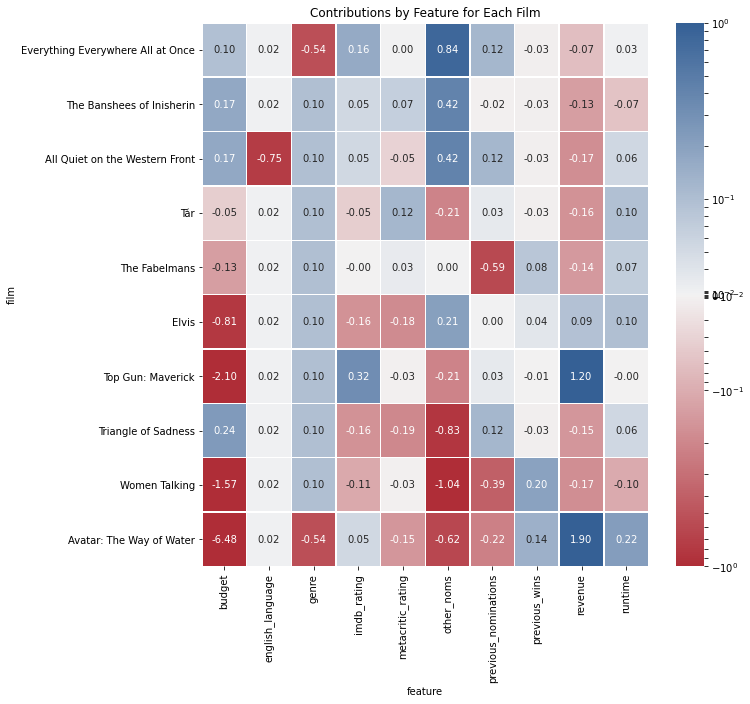

In [1193]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm

# pivot the dataframe to get the contributions by feature for each film
contributions_by_film = contributions_df.pivot(index='film', columns='feature', values='contribution')

# sort the films by predicted_prob in descending order
contributions_by_film = contributions_by_film.loc[contributions_df.sort_values('predicted_prob', ascending=False)['film'].unique()]

# create a heatmap
fig, ax = plt.subplots(figsize=(10, 10))
cmap = sns.diverging_palette(10, 250, s=75, l=40, n=9, center='light', as_cmap=True)
norm = SymLogNorm(linthresh=0.03, linscale=0.03, vmin=-1, vmax=1)
sns.heatmap(contributions_by_film, cmap=cmap, annot=True, fmt='.2f', linewidths=.5, norm=norm)
ax.set_title('Contributions by Feature for Each Film')
plt.show()


## Check last year's winners

In [1194]:
test_2022 = test_df.loc[test_df['year_ceremony'] == 2022]
train_2022 = train_df.loc[train_df['year_ceremony'] == 2022]
lastYear = pd.concat([test_2022, train_2022])

In [1195]:
# Create a table with the features, coefficients, and contribution to the probability of winning
selected_columns = ['name', 'film', 'category'] + selected_features
lastYear = lastYear[selected_columns].copy()

coef = pd.Series(model.coef_[0], index=selected_features)
lastYear["predicted_winner"] = model.predict(lastYear[selected_features])
lastYear["predicted_prob"] = model.predict_proba(lastYear[selected_features])[:, 1]

contributions = []
for idx, row in lastYear.iterrows():
    name = row['name']
    film = row['film']
    category = row['category']
    for feature, coef_val in coef.iteritems():
        feature_value = row[feature]
        contribution = feature_value * coef_val
        contributions.append([name, film, category, feature, coef_val, feature_value, contribution, row['predicted_prob']])

contributions_df = pd.DataFrame(contributions, columns=['name', 'film', 'category', 'feature', 'coefficient', 'feature_value', 'contribution', 'predicted_prob'])


In [1196]:
# replace genre column names with 'genre'
genre_columns = ['Documentary', 'Horror', 'War', 'Thriller', 'Comedy', 'Family',
                 'TV Movie', 'Music', 'Western', 'Adventure', 'Drama', 'Romance',
                 'Action', 'Science Fiction', 'Fantasy', 'History', 'Mystery',
                 'Animation', 'Crime']

contributions_df.replace(to_replace=genre_columns, value='genre', inplace=True)

foo = pd.DataFrame(contributions_df.groupby(['name','film','feature']).agg({'contribution':'sum','predicted_prob':'mean'})).reset_index()

foo = pd.DataFrame(foo.
             groupby(['film','feature'])['predicted_prob','contribution'].mean()).sort_values(by='predicted_prob',ascending=False)

bar = foo.reset_index()

<ipython-input-1196-42ce5ae61c93>:11: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  foo = pd.DataFrame(foo.


In [1197]:
pd.DataFrame(bar.groupby('film')['predicted_prob'].mean()).reset_index().sort_values('predicted_prob',ascending=False)

,film,predicted_prob
7,The Power of the Dog,0.148858
0,Belfast,0.053008
1,CODA,0.039244
4,King Richard,0.021246
2,Drive My Car,0.019190
5,Licorice Pizza,0.009347
3,Dune,0.005218
8,West Side Story,0.005064
6,Nightmare Alley,0.003907


<ipython-input-1198-45c92bbd4037>:14: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  norm = SymLogNorm(linthresh=0.03, linscale=0.03, vmin=-1, vmax=1)


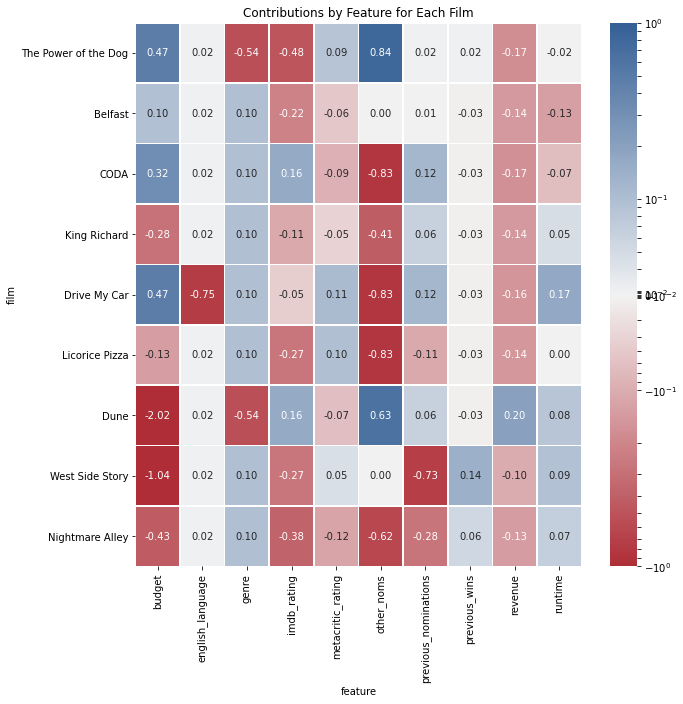

In [1198]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm

# pivot the dataframe to get the contributions by feature for each film
contributions_by_film = bar.pivot(index='film', columns='feature', values='contribution')

# sort the films by predicted_prob in descending order
contributions_by_film = contributions_by_film.loc[bar.sort_values('predicted_prob', ascending=False)['film'].unique()]

# create a heatmap
fig, ax = plt.subplots(figsize=(10, 10))
cmap = sns.diverging_palette(10, 250, s=75, l=40, n=9, center='light', as_cmap=True)
norm = SymLogNorm(linthresh=0.03, linscale=0.03, vmin=-1, vmax=1)
sns.heatmap(contributions_by_film, cmap=cmap, annot=True, fmt='.2f', linewidths=.5, norm=norm)
ax.set_title('Contributions by Feature for Each Film')
plt.show()
